In [1]:
import functions as f
import dictionaries as di
from functions import load_songs_from_xml, random_sample_df, reverse_dictionary, calculate_new_tempo, nml_key_int_to_name
from dictionaries import harmonic_to_note
import importlib as imp
from dictionaries import harmonic_to_note
note_to_harmonic = reverse_dictionary(harmonic_to_note)
from functions import load_songs_from_xml, random_sample_df, reverse_dictionary
import pandas as pd

import paralell_graph
from paralell_graph import parallel_job

In [110]:
file = "BREAK_ALL.nml"
file = "BreakBeat not listened.nml"
file = "Breakbeat2023-09.nml"
file = "temp.nml"

df = load_songs_from_xml(file)
sampled_df = random_sample_df(df, n_samples=0)

In [113]:
new_rows = []
def row_skipper(row=row, comment="-r"):
    try:
        if comment in row.Comment:
            None
        else:
            return True
    except:
        return True

In [105]:
# List to hold the new rows
new_rows = []

SEMITONES = [-2, -1, 0, 1, 2]
bpm_semitone_threshold = 0.25

# Replace 'sampled_df' with your actual DataFrame variable name
for row in sampled_df.itertuples(index=False):  # Assuming you don't need the DataFrame index
    # Check if the row contains the '-r' comment
    try:
        if "-r" not in row.Comment:
            continue
    except:
        for semitone_change in SEMITONES:
            new_tempo = calculate_new_tempo(row.BPM, semitone_change)
            new_key_int = (row.Musical_Key_Int - 1 + semitone_change) % 24 + 1
            musical_key = nml_key_int_to_name(new_key_int)
            harmonic_key = note_to_harmonic[musical_key]

            # Create a dictionary for the new row
            new_row = {
                "ID": row.ID,
                "Artist": row.Artist,
                "Title": row.Title,
                "File_Path": row.File_Path,
                "Play_Count": row.Play_Count,
                "Comment": row.Comment,
                "Color": row.Color,
                "BPM": new_tempo,
                "BPM_max": calculate_new_tempo(new_tempo, bpm_semitone_threshold),
                "BPM_min": calculate_new_tempo(new_tempo, -bpm_semitone_threshold),
                "Musical_Key_Int": new_key_int,
                "Musical_Key": musical_key,
                "Harmonic_Key": harmonic_key,
                "Kind": "Calculated"
            }

            # Add the new row to the list
            new_rows.append(new_row)
        else:
            None

# Create a new DataFrame from the list of new rows
new_df = pd.DataFrame(new_rows)
# df_combined = pd.concat([sampled_df, new_df], ignore_index=True)
df_combined = new_df

In [107]:
for row in df_combined.itertuples(index=False):
    try:
        if "-r" in row.Comment:
            print(row.Comment)
    except:
        print(row.Comment)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


## Weighted Network 

In [5]:
def get_key_number(key):
    return int(key[:-1])

def get_key_letter(key):
    return key[-1]

def get_weight(mix_type):
    weights = {
        'perfect_mix': 10,
        'minus_1_mix': 10,
        'plus_1_mix': 10,
        'scale_change': 8,
        'energy_boost': 8,
        'mood_shifter': 6
    }
    return weights.get(mix_type, 0)

def get_mix_type(base_key, compare_key):
    # Convert key codes to numbers and letters
    base_number = get_key_number(base_key)
    compare_number = get_key_number(compare_key)
    base_letter = get_key_letter(base_key)
    compare_letter = get_key_letter(compare_key)

    # Define transitions for different mix types
    transitions = {
        0: ['perfect_mix', 'scale_change'],
        1: ['minus_1_mix', 'plus_1_mix'],
        2: ['energy_boost'],
        3: ['scale_change'],

    }
    diff = abs(base_number - compare_number) % 12
    
    if diff > 6:
        diff = 12 - diff
    print(diff)

    ### Perfect mix is tested, good
    if diff == 0 and base_letter == compare_letter:
        return 'perfect_mix'
    elif diff == 0 and base_letter != compare_letter:
        return 'scale_change'
    
    # !!!!!!!!!!!!! NEEDES TO BE TESTED
    elif diff == 1 and base_letter == compare_letter:
        if base_number % 12 > compare_number % 12:
            return 'minus_1_mix'
        else:
            return 'plus_1_mix'
        
    # !!!!!!!!!!!!! NEEDES TO BE TESTED
    elif diff == 2 and base_letter == compare_letter:
        return 'energy_boost'
    
    ### Mood shifter is tested, good
    elif diff == 3 and base_letter != compare_letter:
        if (base_number + 3) % 12 == compare_number % 12 and base_letter == 'a':
            return 'mood_shifter'
        elif (base_number - 3) % 12 == compare_number % 12 and base_letter == 'b':
            return 'mood_shifter'
        else:
            return 'unknown'
    
    else:
        return 'unknown'

# Example usage:
mix_type = get_mix_type('11b', '2a')
print(mix_type)
mix_type = get_mix_type('6b', '3a')
print(mix_type)
mix_type = get_mix_type('8a', '9a')
print(mix_type)
mix_type = get_mix_type('10b', '1a')
print(mix_type)
mix_type = get_mix_type('12b', '10b')
print(mix_type)

3
unknown
3
mood_shifter
1
plus_1_mix
3
unknown
2
energy_boost


In [6]:
import numpy as np

# Example data arrays
base_keys = np.array(['1A', '2B', '3A', '4B', '5A'])
compare_keys = np.array(['2A', '1B', '6B', '5A', '4B'])

# Extract numeric and letter parts
base_key_nums = np.char.strip(base_keys, 'AB').astype(int)
base_key_letters = np.char.strip(base_keys, '1234567890')
compare_key_nums = np.char.strip(compare_keys, 'AB').astype(int)
compare_key_letters = np.char.strip(compare_keys, '1234567890')

# Calculate differences
num_diff = (compare_key_nums - base_key_nums) % 12
letter_diff = base_key_letters != compare_key_letters

# Initialize mix type array
mix_types = np.full(base_keys.shape, 'unknown', dtype='<U12')

# Apply vectorized conditions
mix_types[(num_diff == 0) & ~letter_diff] = 'perfect_mix'
mix_types[(num_diff == 0) & letter_diff] = 'scale_change'
mix_types[(num_diff == 1) & ~letter_diff] = 'plus_1_mix'
mix_types[(num_diff == 11) & letter_diff] = 'minus_1_mix'
mix_types[(num_diff == 2) & ~letter_diff] = 'energy_boost'

# Complex logic that's not easily vectorizable, like mood_shifter, will need a different approach
# Here's one way to handle it with a loop (though this part is not vectorized):
for i in range(len(base_keys)):
    if (num_diff[i] == 3 and letter_diff[i] and
       (base_key_letters[i] == 'A' and (base_key_nums[i] + 3) % 12 == compare_key_nums[i] % 12) or
       (base_key_letters[i] == 'B' and (base_key_nums[i] - 3) % 12 == compare_key_nums[i] % 12)):
        mix_types[i] = 'mood_shifter'

# Display the mix types
print(mix_types)

['plus_1_mix' 'unknown' 'mood_shifter' 'unknown' 'minus_1_mix']


In [6]:
node_list = set(sampled_df.ID)
edge_list = []     
for row_base in df_combined.itertuples():
    for row_to_compare in df_combined.itertuples():
        if row_base.ID == row_to_compare.ID:
            None
        else:
            # first filter, song is whennever between ranges? 
            if row_base.BPM_max >= row_to_compare.BPM and row_base.BPM_min <= row_to_compare.BPM:
                # only a temporary function:
                if row_base.Musical_Key_Int == row_to_compare.Musical_Key_Int:
                    edge_list.append((row_base.ID, row_to_compare.ID))
                else:
                    None
                if row_to_compare.Harmonic_Key in f.get_classic_neighbours(row_base.Harmonic_Key):    
                    #print(row_base.ID, row_to_compare.ID)
                    edge_list.append((row_base.ID, row_to_compare.ID))
                else:
                    None
            else:
                None

### 🐌 Try to make a faster itertuples implementation

In [41]:
"""node_list = set(sampled_df.ID)
edge_list = []     
for row_base in df_combined.itertuples():
    for row_to_compare in df_combined.itertuples():
        if row_base.ID == row_to_compare.ID:
            None
        else:
            # first filter, song is whennever between ranges? 
            if row_base.BPM_max >= row_to_compare.BPM and row_base.BPM_min <= row_to_compare.BPM:
                # only a temporary function:
                if row_base.Musical_Key_Int == row_to_compare.Musical_Key_Int:
                    edge_list.append((row_base.ID, row_to_compare.ID))
                else:
                    None
                if row_to_compare.Harmonic_Key in f.get_classic_neighbours(row_base.Harmonic_Key):    
                    #print(row_base.ID, row_to_compare.ID)
                    edge_list.append((row_base.ID, row_to_compare.ID))
                else:
                    None
            else:
                None"""

### 🏃‍♀️ Fast comparisson

In [88]:
def fast_comparisson(df):
    df_list = df.values.tolist()
    edge_list_to_list = []
    for row_base in df_list:
        for row_to_compare in df_list:
            if row_base[0] == row_to_compare[0]:
                None
            else:
                # first filter, song is whennever between ranges? 
                if row_base[7] >= row_to_compare[6] and row_base[8] <= row_to_compare[6]:
                    # only a temporary function:
                    if row_base[9] == row_to_compare[9]:
                        edge_list_to_list.append((row_base[0], row_to_compare[0]))
                    else:
                        None
                    if row_to_compare[12] in f.get_classic_neighbours(row_base[12]):    
                        #print(row_base.ID, row_to_compare.ID)
                        edge_list_to_list.append((row_base[0], row_to_compare[0]))
                    else:
                        None
                else:
                    None
    return edge_list_to_list

edge_list = fast_comparisson(df_combined)


## 🚅 Fastest --- this is not fast at all

In [46]:
edge_list = parallel_job(df_combined, cores=8)

In [89]:
import networkx as nx

# Assuming 'edge_list' is already defined as shown in your example

# Create a graph from the edge list
G = nx.DiGraph()
G.add_edges_from(edge_list)

# Now, you can access edges connected to a specific node
node_id = list(G.nodes())[5]  # Example node ID
connected_nodes = list(G.successors(node_id))

print(f"Nodes directly connected to node {node_id}: {connected_nodes}")

Nodes directly connected to node 62: [1, 6, 28, 29, 48, 69, 88, 106, 113, 128, 132, 165, 178, 188, 225, 264, 267, 278, 280, 294, 297, 346, 348, 364, 369, 420, 455, 501, 525, 569, 609, 610]


In the context of directed graphs, such as the one represented by a DiGraph object in NetworkX, the "in-degree" of a node refers to the number of edges coming into that node from other nodes. More specifically, if you have a directed edge from node A to node B, this contributes to the in-degree of node B.

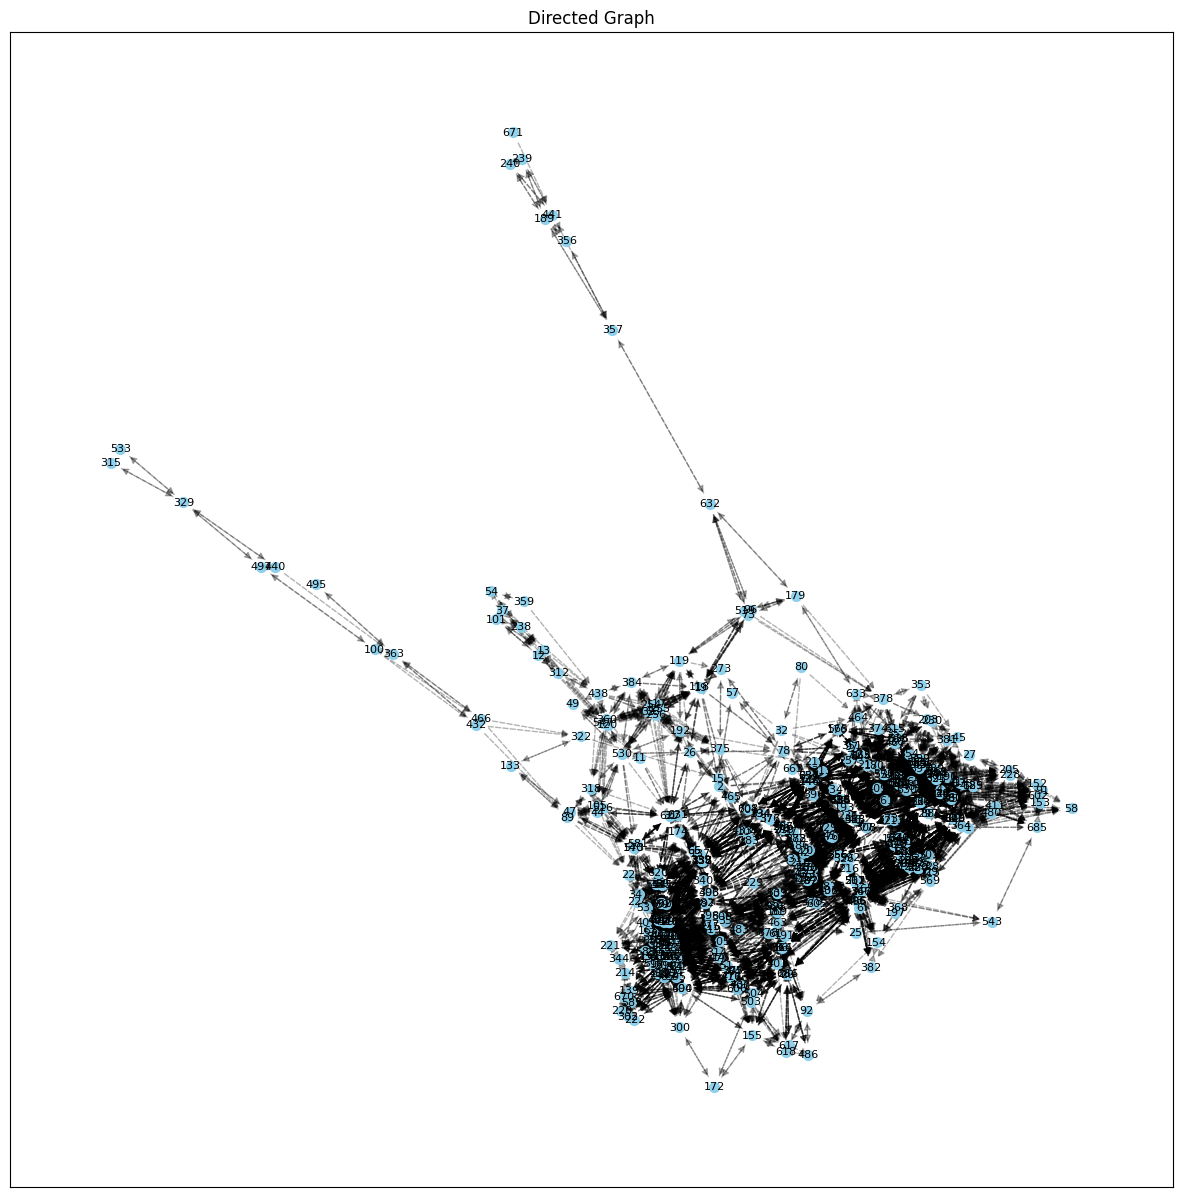

In [90]:
f.plot_a_graph(f.keep_largest_cluster(G))

In [93]:
# Assuming G is your directed graph (DiGraph)
import random 

def random_unique_path(G, path_length):
    if len(G) < path_length:
        raise ValueError("Graph has fewer nodes than the desired path length.")
    
    # Start from a random node
    path = [random.choice(list(G.nodes()))]
    
    # Try to find a path with the specified length
    while len(path) < path_length:
        # Get the neighbors of the last node in the path
        neighbors = list(G.successors(path[-1]))
        # Filter out neighbors that are already in the path
        neighbors = [node for node in neighbors if node not in path]
        
        if not neighbors:
            # If there are no neighbors that haven't been visited, start over
            path = [random.choice(list(G.nodes()))]
        else:
            # Randomly select one of the unvisited neighbors
            path.append(random.choice(neighbors))
    
    return path

# Generate a random unique path of 20 nodes
path_length = 20
random_path = random_unique_path(f.keep_largest_cluster(G), path_length)

print("Random unique path:", random_path)

Random unique path: [457, 138, 338, 116, 167, 139, 490, 277, 64, 86, 504, 266, 503, 316, 564, 455, 401, 191, 511, 341]


In [94]:
for i in random_path:
    #print(df.loc[df.ID == i, ["Title", "BPM", "Musical_Key", "Kind"]])
    display(df_combined.loc[df_combined.ID == i])

,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
456,457,None,Sergey Hairulin group - Damaged (Steve Maccabe...,//DJ//SELECTOR//Sergey Hairulin group - Damage...,,None,128,130.99217,125.076774,12,,Cm,5a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
137,138,Dan F,Go See Your Doctor,//DJ//SELECTOR//Dan F - Go See Your Doctor.mp3,,None,127,130.991647,125.076275,12,,Cm,5a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
337,338,None,"Meat Katie, Dylan Rhymes - Dense(1)","//DJ//SELECTOR//Meat Katie, Dylan Rhymes - Den...",,None,128,130.992202,125.076804,12,,Cm,5a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
115,116,Cut La Roc Featuring Coppa,Supa Disco (Cakeboy Remix),//DJ//SELECTOR//Cut La Roc Featuring Coppa - S...,,None,129,133.038309,127.030513,17,,Fm,4a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
166,167,None,Dylan Rhymes - Salty,//DJ//SELECTOR//Dylan Rhymes - Salty.mp3,,electrish,130,133.705886,127.667942,22,3,Bbm,3a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
138,139,Dan F,Morocco (2014 remaster),//DJ//SELECTOR//Dan F - Morocco (2014 remaster...,1,lot of bass,133,137.131945,130.939286,1,2,Db,3b,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
489,490,StepSine,Step Up,//DJ//SELECTOR//StepSine - Step Up.mp3,1,slower middle -r,136,139.179099,132.893994,22,2,Bbm,3a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
276,277,Kelle,Death Of Habit (Original Mix),//DJ//SELECTOR//Kelle - Death Of Habit (Origin...,,-r,135,138.15574,131.916849,15,1,Ebm,2a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
63,64,None,Bassbin Twins vs. Mr No Hands - Adrenaline Ltd,//DJ//SELECTOR//Bassbin Twins vs. Mr No Hands ...,,happy electro break,134,138.13441,131.896482,15,3,Ebm,2a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
85,86,None,BreakZhead - Disaster,//DJ//SELECTOR//BreakZhead - Disaster.mp3,1,None,135,138.155538,131.916655,20,2,Abm,1a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
503,504,None,Subface - Junkee Beats,//DJ//SELECTOR//Subface - Junkee Beats.mp3,,None,136,139.884262,133.567313,15,1,Ebm,2a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
265,266,None,"KL2, Steppa Style - Mash It Up (Freefall Colle...","//DJ//SELECTOR//KL2, Steppa Style - Mash It Up...",,None,137,140.208532,133.87694,20,,Abm,1a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
502,503,None,Subface - Junkee Beats(1),//DJ//SELECTOR//Subface - Junkee Beats(1).mp3,,None,137,140.20227,133.870961,15,,Ebm,2a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
315,316,M Spark,Pure Mind (Original Mix),//DJ//SELECTOR//M Spark - Pure Mind (Original ...,,! -r,135,138.155522,131.916641,20,2,Abm,1a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
563,564,Z-Neo,Z-Neo – New Hope EP – ℗ 2021 - What Ever It Takes,//DJ//SELECTOR//Z-Neo – New Hope EP – ℗ 2021 -...,1,None,134,138.080693,131.845191,20,,Abm,1a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
454,455,Sergei Orange,Eruption [RUNE :: FREE TUNE],//DJ//SELECTOR//Sergei Orange - Eruption _ RUN...,1,harchz,135,138.165797,131.926451,13,2,Dbm,12a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
400,401,Plastic Shell,Cone Stuck (Original Mix),//DJ//SELECTOR//Plastic Shell - Cone Stuck (Or...,,hm -r,135,139.178709,132.893622,20,5,Abm,1a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
190,191,None,Forufreezer - Xumen (Original Mix),//DJ//SELECTOR//Forufreezer - Xumen (Original ...,,?,134,137.132304,130.939629,20,1,Abm,1a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
510,511,T.R.O.,Plattegroove (Original Mix),//DJ//SELECTOR//T.R.O. - Plattegroove (Origina...,,-r,131,135.085307,128.985071,13,2,Dbm,12a,Base


,ID,Artist,Title,File_Path,Play_Count,Comment,BPM,BPM_max,BPM_min,Musical_Key_Int,Color,Musical_Key,Harmonic_Key,Kind
340,341,Mechanical Pressure & Daria Re,Trust Fall (Tom Clyde Remix),//DJ//SELECTOR//Mechanical Pressure & Daria Re...,,prog vocal -r,129,133.038294,127.030498,18,2,Gbm,11a,Base


In [83]:
# Specify the drive letter that is missing from your file paths
drive_letter = "E:"

# Create the M3U file
with open("playlist.m3u", "w") as m3u_file:
    for i in random_path:
        # Retrieve the file path for the given ID and prepend the drive letterth)
        file_path = df.loc[df.ID == i].File_Path.values[0]
        full_path = drive_letter + file_path.replace('//', '\\')
        print(full_path)
        # Write the full path to the M3U file
        m3u_file.write(full_path + "\n")

print("M3U playlist created as 'playlist.m3u'.")

E:\DJ\SELECTOR\4kuba - Dear Mate (Dopamine Remix) https vk.com dustychest Vinyl Store.mp3
E:\DJ\SELECTOR\Code Rising - Unknown Entry Event.mp3
E:\DJ\SELECTOR\Kondra (ft. Jaxx) - Can't Have Me (Smithmonger Remix).mp3
E:\DJ\SELECTOR\Noisia vs. The Prodigy - Gutters Of Narayan (c-Row's 40k reboot).wav
E:\DJ\SELECTOR\Llupa - Shadow Walker (Original Mix).mp3
E:\DJ\SELECTOR\General Midi - F.U.N.K(1).mp3
E:\DJ\SELECTOR\Mark Ronson - Record Collection (Bobalino's If The Plumps Still Made Breaks Remo(1).mp3
E:\DJ\SELECTOR\Sam Vandal - Fires (Karl Sav Remix)[BIG UP MUSIC].mp3
E:\DJ\SELECTOR\Tie Fighters - Afterglow (Original mix).mp3
E:\DJ\SELECTOR\Sketi - Blast Off .mp3
E:\DJ\SELECTOR\Afrika Bambaataa feat. Hardy Hard & Lady Waks - Shake It (Original Mix).mp3
E:\DJ\SELECTOR\Soul Of Man - Foxy Moron (Original Mix).mp3
E:\DJ\SELECTOR\Rob Dougan - Clubbed To Death (Hybrid Remix).mp3
E:\DJ\SELECTOR\Anthony Rother - Neon Space.mp3
E:\DJ\SELECTOR\4KUBA - Dear Mate (Epidemic Version).mp3
E:\DJ\SELECTO

[164,
 342,
 478,
 125,
 159,
 593,
 21,
 432,
 244,
 306,
 322,
 339,
 6,
 38,
 597,
 243,
 58,
 451,
 428,
 280]